In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

#TODO: remove the following hack from https://stackoverflow.com/questions/69687794/unable-to-manually-load-cifar10-dataset
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

#Scale the pixel values
X_train_full, X_test = X_train_full/255.0, X_test/255.0
y_train_full, y_test = y_train_full.flatten(), y_test.flatten()

X_train,X_valid,y_train,y_valid = train_test_split(X_train_full,y_train_full, random_state=42)

In [3]:
%load_ext tensorboard

%tensorboard --logdir logs/fit


Reusing TensorBoard on port 6006 (pid 22460), started 0:38:55 ago. (Use '!kill 22460' to kill it.)

In [4]:
X_train.shape, y_train.shape

((37500, 32, 32, 3), (37500,))

In [5]:
y_train[0]

0

### Exercises from Geron chapter 11
Nadam with 20 layers of 100 neurons, He initialization and  Elu

Dropout

In [6]:
from functools import partial
elu_layer = partial(keras.layers.Dense,kernel_initializer="he_normal", activation="elu")


def make_DNN_dropout (layer_function, n_hidden,use_normalization=False, dropout_rate=-1):
    architecture = [keras.layers.Flatten(input_shape=[32,32,3])]
    for _ in range(n_hidden):
        architecture.append(layer_function(100))
        if use_normalization:
            architecture.append(keras.layers.BatchNormalization())
        if dropout_rate > -1:
            architecture.append(keras.layers.Dropout(dropout_rate))
    architecture.append(keras.layers.Dense(10,activation="softmax"))
    return(keras.models.Sequential(architecture))

def dropout_model():
    return make_DNN_dropout(elu_layer,20,False,0.2)

#First run used the values that worked well for he & elu without dropout - performed badly -  best validn accuracy was 22.34%
#lrs=[0.001, 0.0005, 0.00025, 0.0001, 0.00005] 
#Tried 0.1 and 0.05 and  but both failed because of instability causing tensorboard: "InvalidArgumentError: Nan in summary histogram for"
#lrs=[0.01, 0.025, 0.05, 0.075] #0.01 => 9.75% 0.025 failed in tensorboard
# lrs=[0.05, 0.075]

# valid_accuracy,test_accuracy,logs = tune_lrs(dropout_model, lrs, "dropout")

# print(f"validation accuracy: {valid_accuracy}")
# print(f"test accuracy: {test_accuracy}")

In [7]:
def tune_lrs(model_function, lrs, prefix):

    import datetime
    import numpy as np

    valid_accuracy=[]
    test_accuracy=[]
    logs=[]
    best_models=[]
    for lr in lrs:
        model = model_function()

        log_dir = "logs/fit/" + f"{prefix}_{lr}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
        checkpoint_file = "models/" + f"{prefix}_{lr}_model.h5"
        tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        #since y_train is numeric rarther than one-hot need to use "SPARSE_categorical_cross_entropy"
        #model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=["accuracy"])
        model.compile(optimizer = keras.optimizers.Nadam(learning_rate=lr) , loss='sparse_categorical_crossentropy', metrics=["accuracy"])
        logs.append(log_dir)


        print(f"fitting lr = {lr} Logged in: {log_dir} saved in {checkpoint_file}")

        model_checkpoint_cb = keras.callbacks.ModelCheckpoint(checkpoint_file, save_best_only=True)

        model.fit(X_train,y_train, epochs=100, validation_data=(X_valid, y_valid), 
            callbacks=[keras.callbacks.EarlyStopping(patience=10), model_checkpoint_cb, tensorboard_cb])
        
        best_models.append(checkpoint_file)

        valid_accuracy.append(model.evaluate(X_valid,y_valid)[1])
        test_accuracy.append(model.evaluate(X_test,y_test)[1])

        
    print(f"Best validation performance: {np.max(valid_accuracy):.2%} for lr: {lrs[np.argmax(valid_accuracy)]}")
    print(f"Best test performance: {np.max(test_accuracy):.2%} for lr: {lrs[np.argmax(test_accuracy)]}")
    return valid_accuracy,test_accuracy,logs, best_models

In [8]:
#0.2 dropout rate was terrible so trying with 0.1
def dropout_model_new():
    return make_DNN_dropout(elu_layer,20,False,0.1)

lrs=[0.001, 0.0005, 0.00025, 0.0001, 0.00005] # back to original he values

valid_accuracy,test_accuracy,logs, best_models = tune_lrs(dropout_model_new, lrs, "dropout")

print(f"validation accuracy: {valid_accuracy}")
print(f"test accuracy: {test_accuracy}")


import numpy as np
test_acc = []
for _,model_file in enumerate(best_models):
    model = dropout_model_new()
    model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    model.load_weights(model_file)
    print(f"model: {model_file}")
    print(f"validation accuracy: {model.evaluate(X_valid,y_valid)[1]:.2%}")
    test_acc.append(model.evaluate(X_test,y_test)[1])
    print(f"test accuracy {test_acc[-1]:.2%}")

print(f"Best test accuracy with 0.1 dropout: {np.max(test_acc):.2%} with lr: {lrs[np.argmax(test_acc)]}")


    

fitting lr = 0.001 Logged in: logs/fit/dropout_0.001_20220704-131800 saved in models/dropout_0.001_model.h5
Epoch 1/100
   1/1172 [..............................] - ETA: 0s - loss: 9.8958 - accuracy: 0.1562WARNING:tensorflow:From c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1172/1172 [==============================] - 11s 9ms/step - loss: 2.5053 - accuracy: 0.1036 - val_loss: 2.3015 - val_accuracy: 0.1087
Epoch 2/100
1172/1172 [==============================] - 11s 9ms/step - loss: 2.1998 - accuracy: 0.1558 - val_loss: 2.1789 - val_accuracy: 0.1737
Epoch 3/100
1172/1172 [==============================] - 10s 9ms/step - loss: 2.1067 - accuracy: 0.1712 - val_loss: 2.0442 - val_accuracy: 0.1994
Epoch 4/100
1172/1172 [==============================] - 1

* Choice of dropout percentage is critical 20% failed completely, 10% worked reasonably well
* Not full tuned because of time but roughly equivalent performance to Nadam with batch normalisation

In [20]:
print(test_acc)
print(best_models)

[0.2556000053882599, 0.4302999973297119, 0.49129998683929443, 0.5012000203132629, 0.47369998693466187]
['models/dropout_0.001_model.h5', 'models/dropout_0.0005_model.h5', 'models/dropout_0.00025_model.h5', 'models/dropout_0.0001_model.h5', 'models/dropout_5e-05_model.h5']


In [23]:
model = dropout_model_new()
model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"])
model.load_weights("models/dropout_0.0001_model.h5")
print(f"test accuracy: {model.evaluate(X_test,y_test)[1]:.2%}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4230 - accuracy: 0.5012
test accuracy: 50.12%


In [29]:
#Monte-carlo dropout on best performing on validation set
import numpy as np

model = dropout_model_new()
model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"])
model.load_weights("models/dropout_0.0001_model.h5")


#This is softmax classification so prediction will be probabilities for the 10 types
y_preds = np.stack([model(X_test,training=True) for sample in range(2000)])
y_pred = y_preds.mean(axis=0)
y_pred = np.argmax(y_pred, axis=1)
accuracy = np.sum(y_pred == y_test)/len(y_test)
print(accuracy)




0.5015


In [33]:
y_pred_1 = y_preds.mean(axis=0)
y_pred_2 = np.argmax(y_pred_1, axis=1)
accuracy = np.sum(y_pred_2 == y_test)/len(y_test)
print(accuracy)

0.5015


In [43]:
#Analysis of y_preds

#so I don't accidentally mess up 12 minute of predictions
my_copy = y_preds.copy()
acc=[]

for _ in range(2,2000):
    preds = my_copy[:_,:,:]
    pred_1 = preds.mean(axis=0)
    y_pred = np.argmax(pred_1, axis=1)
    accuracy = np.sum(y_pred == y_test)/len(y_test)
    acc.append(accuracy)




In [55]:
#Trying on a sub-optimal model
import numpy as np

model = dropout_model_new()
model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"])
model.load_weights('models/dropout_5e-05_model.h5')
print(f"{model.evaluate(X_test,y_test)[1]:.2%}")


#This is softmax classification so prediction will be probabilities for the 10 types
y_preds_sub = np.stack([model(X_test,training=True) for sample in range(2000)])
y_pred_sub_2 = y_preds_sub.mean(axis=0)
y_pred_sub = np.argmax(y_pred_sub_2, axis=1)
accuracy_sub = np.sum(y_pred_sub == y_test)/len(y_test)
print(accuracy_sub)

313/313 [==============================] - 1s 2ms/step - loss: 1.4796 - accuracy: 0.4737
47.37%
0.4723


In [56]:
#Analysis of y_preds

#so I don't accidentally mess up 12 minute of predictions
my_copy = y_preds_sub.copy()
acc_sub=[]

for _ in range(2,2000):
    preds = my_copy[:_,:,:]
    pred_1 = preds.mean(axis=0)
    y_pred = np.argmax(pred_1, axis=1)
    accuracy = np.sum(y_pred == y_test)/len(y_test)
    acc_sub.append(accuracy)

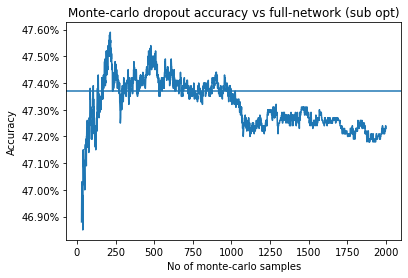

In [57]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.plot(range(30,2000),acc_sub[28:])
plt.title("Monte-carlo dropout accuracy vs full-network (sub opt)")
plt.xlabel("No of monte-carlo samples")
plt.ylabel("Accuracy")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.axhline(y=0.4737)
plt.show()


* Above graph shows full network performance as horizontal line


### Alpha dropout

* Alpha dropout is used with self-regularizing networks (dense and using SELU)

In [4]:
#Start with 0.1 dropout

import tensorflow as tf
from tensorflow import keras
from functools import partial

selu_layer = partial(keras.layers.Dense,kernel_initializer="lecun_normal", activation="selu")

def make_DNN_alpha (layer_function, n_hidden,use_normalization=False,dropout=0.1):
    architecture = [keras.layers.Flatten(input_shape=[32,32,3])]
    architecture.append(keras.layers.AlphaDropout(rate=dropout))
    for _ in range(n_hidden):
        architecture.append(layer_function(100))
        architecture.append(keras.layers.AlphaDropout(rate=dropout))
        
    architecture.append(keras.layers.Dense(10,activation="softmax"))
    return(keras.models.Sequential(architecture))

def selu_alpha_model():
    return make_DNN_alpha(selu_layer,20,False,0.1)

#selu_model().summary()

lrs=[0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001, 0.00005]

valid_accuracy,test_accuracy,logs, best_models = tune_lrs(selu_alpha_model, lrs, "selu_alpha")

print(f"validation accuracy: {valid_accuracy}")
print(f"test accuracy: {test_accuracy}")

fitting lr = 0.01 Logged in: logs/fit/selu_alpha_0.01_20220625-170019
Epoch 1/100
   1/1172 [..............................] - ETA: 0s - loss: 3.0522 - accuracy: 0.0938WARNING:tensorflow:From c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1172/1172 [==============================] - 12s 11ms/step - loss: 84.9952 - accuracy: 0.0997 - val_loss: 2.3584 - val_accuracy: 0.1007
Epoch 2/100
1172/1172 [==============================] - 12s 10ms/step - loss: 2.3660 - accuracy: 0.0954 - val_loss: 2.3846 - val_accuracy: 0.0946
Epoch 3/100
1172/1172 [==============================] - 14s 12ms/step - loss: 2.3618 - accuracy: 0.0990 - val_loss: 2.3915 - val_accuracy: 0.0946
Epoch 4/100
1172/1172 [==============================] - 13s 11ms/step - loss: 2.3629 - accu

In [5]:
def selu_alpha_model_lower():
    return make_DNN_SD(selu_layer,20,False,0.05)

lrs=[0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001, 0.00005]

valid_accuracy,test_accuracy,logs = tune_lrs(selu_alpha_model_lower, lrs, "selu_alpha_lower")

print(f"validation accuracy: {valid_accuracy}")
print(f"test accuracy: {test_accuracy}")

fitting lr = 0.01 Logged in: logs/fit/selu_alpha_lower_0.01_20220625-173633
Epoch 1/100
1172/1172 [==============================] - 16s 13ms/step - loss: 2.5529 - accuracy: 0.0996 - val_loss: 2.4834 - val_accuracy: 0.1007
Epoch 2/100
1172/1172 [==============================] - 13s 11ms/step - loss: 135298272.0000 - accuracy: 0.0995 - val_loss: 3.2790 - val_accuracy: 0.1033
Epoch 3/100
1172/1172 [==============================] - 13s 11ms/step - loss: 3613.2688 - accuracy: 0.0981 - val_loss: 2.6648 - val_accuracy: 0.1033
Epoch 4/100
1172/1172 [==============================] - 13s 11ms/step - loss: 136242.9844 - accuracy: 0.1025 - val_loss: 2.6153 - val_accuracy: 0.1033
Epoch 5/100
1172/1172 [==============================] - 13s 12ms/step - loss: 273.9124 - accuracy: 0.0998 - val_loss: 2.3337 - val_accuracy: 0.1024
Epoch 6/100
1172/1172 [==============================] - 13s 11ms/step - loss: 18.6693 - accuracy: 0.1016 - val_loss: 2.3579 - val_accuracy: 0.1024
Epoch 7/100
1172/1172 [

In [6]:
def selu_alpha_model_even_lower():
    return make_DNN_SD(selu_layer,20,False,0.025)

lrs=[0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001, 0.00005]

valid_accuracy,test_accuracy,logs = tune_lrs(selu_alpha_model_even_lower, lrs, "selu_alpha_even_lower")

print(f"validation accuracy: {valid_accuracy}")
print(f"test accuracy: {test_accuracy}")

fitting lr = 0.01 Logged in: logs/fit/selu_alpha_even_lower_0.01_20220625-184902
Epoch 1/100
1172/1172 [==============================] - 17s 14ms/step - loss: 2.5601 - accuracy: 0.0984 - val_loss: 2.6347 - val_accuracy: 0.1024
Epoch 2/100
1172/1172 [==============================] - 13s 11ms/step - loss: 113155808.0000 - accuracy: 0.0979 - val_loss: 2.6239 - val_accuracy: 0.0970
Epoch 3/100
1172/1172 [==============================] - 14s 12ms/step - loss: 12628.3018 - accuracy: 0.0974 - val_loss: 2.5162 - val_accuracy: 0.1031
Epoch 4/100
1172/1172 [==============================] - 14s 12ms/step - loss: 2.6899 - accuracy: 0.0998 - val_loss: 2.3431 - val_accuracy: 0.0988
Epoch 5/100
1172/1172 [==============================] - 14s 12ms/step - loss: 2.5689 - accuracy: 0.1010 - val_loss: 2.3517 - val_accuracy: 0.0946
Epoch 6/100
1172/1172 [==============================] - 14s 12ms/step - loss: 2.4800 - accuracy: 0.0963 - val_loss: 2.4749 - val_accuracy: 0.1010
Epoch 7/100
1172/1172 [==

In [8]:
logs
#best was 0.0001 "selu_alpha_even_lower_0.0001_model.h5"
def selu_alpha_model_even_lower():
    return make_DNN_SD(selu_layer,20,False,0.025)


model = selu_alpha_model_even_lower()
model.compile(optimizer = keras.optimizers.Nadam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy', metrics=["accuracy"])
model.load_weights("selu_alpha_even_lower_0.0001_model.h5")
#best_model = keras.models.load_model("cifar10_elu_he_0.000_model.h5")
print(f"validation accuracy: {model.evaluate(X_valid,y_valid)[1]:.2%}")
print(f"test accuracy {model.evaluate(X_test,y_test)[1]:.2%}")



391/391 [==============================] - 1s 2ms/step - loss: 1.5190 - accuracy: 0.4800
validation accuracy: 48.00%
313/313 [==============================] - 1s 2ms/step - loss: 1.4999 - accuracy: 0.4875
test accuracy 48.75%


In [9]:
#MC_dropout

import numpy as np


#This is softmax classification so prediction will be prtobabilities for the 10 types
y_preds = np.stack([model(X_valid,training=True) for sample in range(100)])
y_pred = y_preds.mean(axis=0)
y_pred = np.argmax(y_pred, axis=1)
accuracy = np.sum(y_pred == y_valid)/len(y_valid)
print(accuracy)

0.48248
